<a href="https://colab.research.google.com/github/eliastheod77/Corporacion_Favorita_Sales_Forecasting/blob/main/Corporacion_Favorita_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store Sales - Time Series Forecasting / Kaggle Competition
## Scope of the competition
In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

Successful models will be evaluated based on the Root Mean Squared Logarithmic Error (RMSLE), offering an opportunity to address retail challenges and refine forecasting methods.

Competition Link: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview
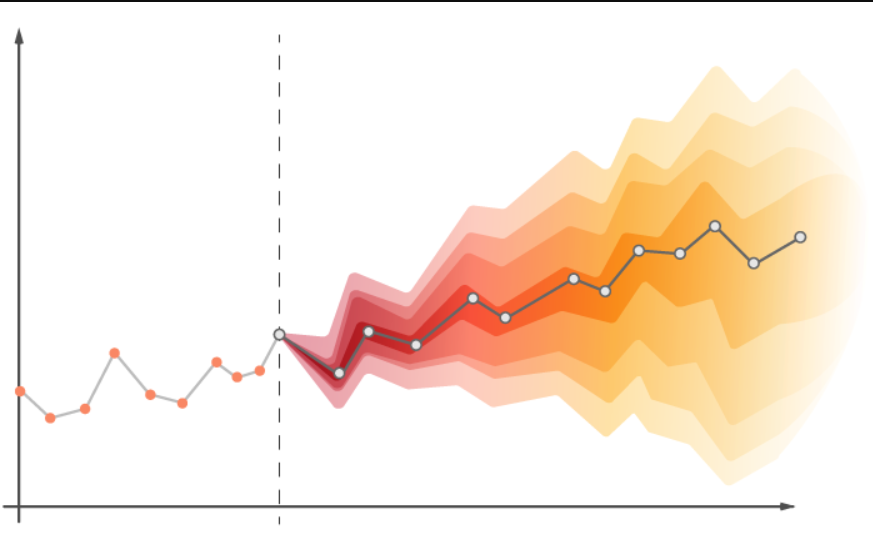

#The first we need to do, is to import the appropriate libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from datetime import datetime, timedelta
import lightgbm as lgb
from lightgbm.callback  import early_stopping
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
%matplotlib inline
import plotly.express as px
#Matplotlib Plot Inline is a package that supports Matplotlib to display plots directly inline and save them to notebooks
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta, date
import xgboost as xgb #the model that we'll use for forecasting. Probably we'll use more
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_log_error
import warnings
import missingno as msno
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from IPython.core.display import display, HTML

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Next step is to upload the datasets

In [ ]:
train = pd.read_csv("//content/drive/MyDrive/Kaggle/Store Sales - Competition/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Kaggle/Store Sales - Competition/test.csv")
holiday_events = pd.read_csv("/content/drive/MyDrive/Kaggle/Store Sales - Competition/holidays_events.csv")
oil_price= pd.read_csv("/content/drive/MyDrive/Kaggle/Store Sales - Competition/oil.csv")
stores = pd.read_csv("/content/drive/MyDrive/Kaggle/Store Sales - Competition/stores.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Kaggle/Store Sales - Competition/transactions.csv")

In [ ]:
# This function helps calculate the sum of null values across all dataframes
def check_data(df):
    """
    Generates a concise summary of DataFrame columns.
    """
# We use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]
# Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [ ]:
# Then we print the summary and check for null values & duplicates across all dataframes
print("Training Data Summary")
display(check_data(train))

print("Test Data Summary")
display(check_data(test))

print("Holidays Events Data Summary")
display(check_data(holiday_events))

print("Oil Data Summary")
display(check_data(oil_price))

print("Stores Data Summary")
display(check_data(stores))

print("Transactions Data Summary")
display(check_data(transactions))

Training Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,id,int64,3000888,3000888,0,0
1,date,object,3000888,1684,0,0
2,store_nbr,int64,3000888,54,0,0
3,family,object,3000888,33,0,0
4,sales,float64,3000888,379610,0,0
5,onpromotion,int64,3000888,362,0,0


Test Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,id,int64,28512,28512,0,0
1,date,object,28512,16,0,0
2,store_nbr,int64,28512,54,0,0
3,family,object,28512,33,0,0
4,onpromotion,int64,28512,212,0,0


Holidays Events Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,date,object,350,312,0,0
1,type,object,350,6,0,0
2,locale,object,350,3,0,0
3,locale_name,object,350,24,0,0
4,description,object,350,103,0,0
5,transferred,bool,350,2,0,0


Oil Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,date,object,1218,1218,0,0
1,dcoilwtico,float64,1175,998,43,0


Stores Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,store_nbr,int64,54,54,0,0
1,city,object,54,22,0,0
2,state,object,54,16,0,0
3,type,object,54,5,0,0
4,cluster,int64,54,17,0,0


Transactions Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,date,object,83488,1682,0,0
1,store_nbr,int64,83488,54,0,0
2,transactions,int64,83488,4993,0,0


#Let's explore the train dataset

In [ ]:
train.head()
# We are trying to predict the sales of family of products, like Seafood on a particular day, not every individual product

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [ ]:
# We calculate the total daily sales throughout the train dataset
train.date = pd.to_datetime(train.date, errors='coerce')
train['weekday'] = train.date.dt.day_name()

start_date =train.date.min()
train['week'] = (((train.date - start_date).dt.days)/7).astype(int)

In [ ]:
# We use the matplotlib plotting library to plot the total daily product famlily sales, for the available dataset
import plotly.express as px

df_plot = train[['date','sales']].groupby(['date']).sum().reset_index()
fig = px.line(df_plot, x="date", y="sales", title='Total Sales by Date 2013-2017')
fig.show()

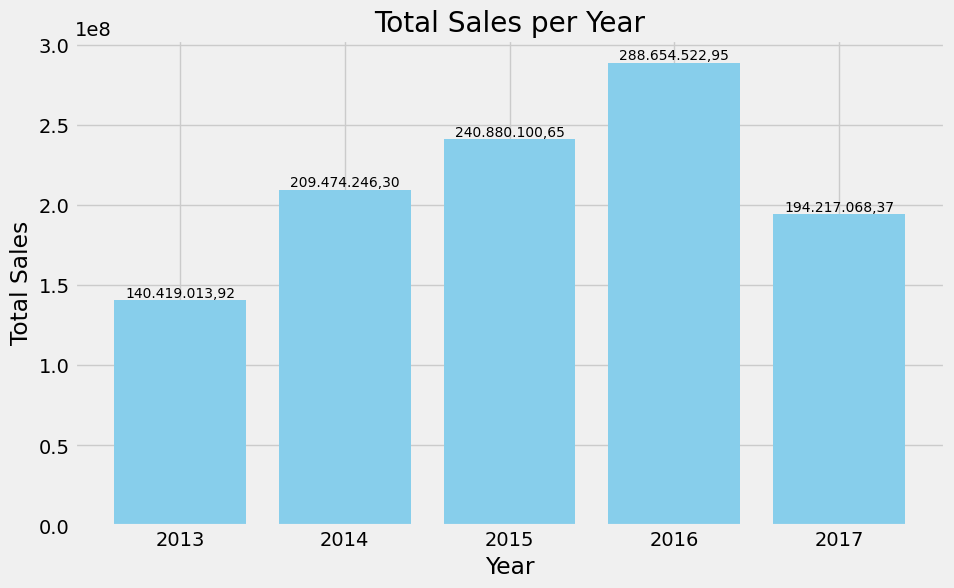

In [ ]:
total_sales_per_year = train.groupby('year')['sales'].sum().reset_index()

def format_number(num):
    return '{:,.2f}'.format(num).replace(',', 'X').replace('.', ',').replace('X', '.')

# Plot the total sales per year
plt.figure(figsize=(10, 6))
bars = plt.bar(total_sales_per_year['year'], total_sales_per_year['sales'], color='skyblue')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales per Year')
plt.xticks(total_sales_per_year['year'])

# Display the values on top of each bar with 2 decimal places
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0, height,
        format_number(height),
        ha='center', va='bottom', fontsize=10
    )

plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales per Year')
plt.show()

<ipython-input-81-e24f4265ee57>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




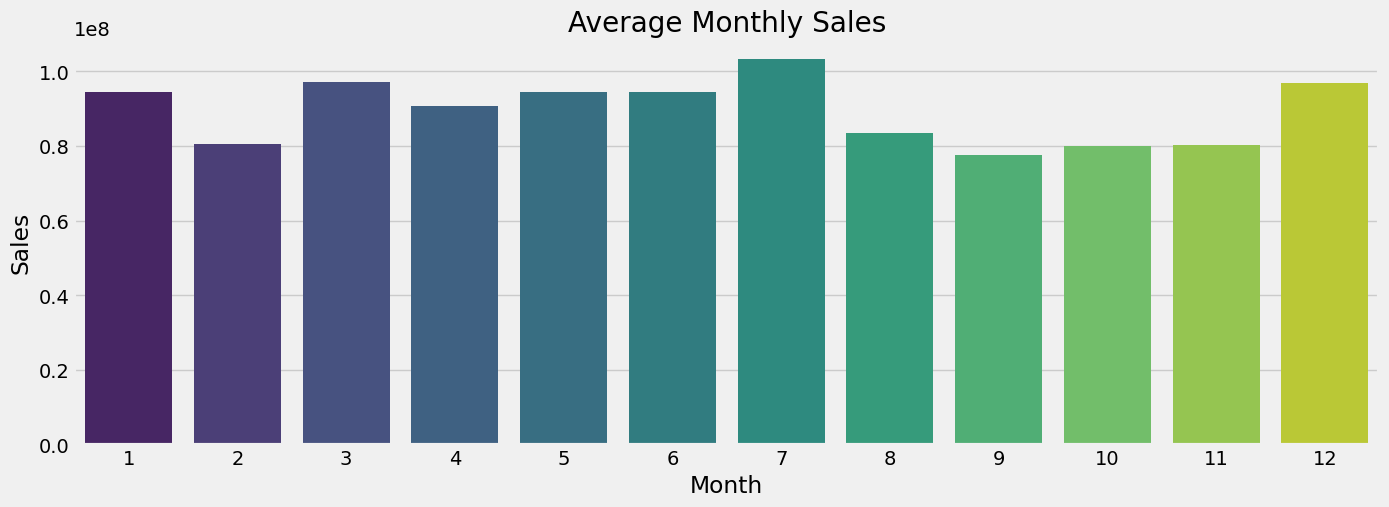

In [ ]:
plt.figure(figsize=(15,5))
monthly_unit_sales = train.groupby(['month'], as_index= False).agg({'sales':'sum'})
sns.barplot(data=monthly_unit_sales, x=monthly_unit_sales.month, y=monthly_unit_sales.sales)
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(rotation = 'horizontal')
# Plot the average sales per month as a bar chart

ax = sns.barplot(data=monthly_unit_sales, x='month', y='sales', palette='viridis')
plt.show()

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,weekday,week,year
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,Tuesday,0,2013
1,1,2013-01-01,1,BABY CARE,0.00,0,Tuesday,0,2013
2,2,2013-01-01,1,BEAUTY,0.00,0,Tuesday,0,2013
3,3,2013-01-01,1,BEVERAGES,0.00,0,Tuesday,0,2013
4,4,2013-01-01,1,BOOKS,0.00,0,Tuesday,0,2013


In [ ]:
# Let's analyze the sales data to understand the distribution of sales across different days of the week.

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Obtain data aggregated by weekday.
df_plot = train[['weekday','sales']].groupby(['weekday']).sum().reset_index()
# Sort by day of week
df_plot = df_plot.set_index("weekday").loc[day_order].reset_index()

fig = px.bar(df_plot, x='weekday', y='sales', title='Total Sales by Day of Week')
fig.show()

In [ ]:
# We calculate the average sales by month
train_data = train.copy()
train_data.set_index('date', inplace = True)
monthly_avg_sales= train_data.resample('M').sales.mean().reset_index()
monthly_avg_sales.head(10)

# We plot this information with a scatter plot and the trendline. As expected sales based on the available information, sales tend to increase over time
px.scatter(monthly_avg_sales, x = "date", y = "sales", trendline = "ols", trendline_color_override = "red", title = 'Monthly Average Sales, 2013 - 2017')

In [ ]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion,weekday,week
3000883,3000883,2017-08-15,9,POULTRY,438.13,0,Tuesday,241
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55,1,Tuesday,241
3000885,3000885,2017-08-15,9,PRODUCE,2419.73,148,Tuesday,241
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,Tuesday,241
3000887,3000887,2017-08-15,9,SEAFOOD,16.00,0,Tuesday,241


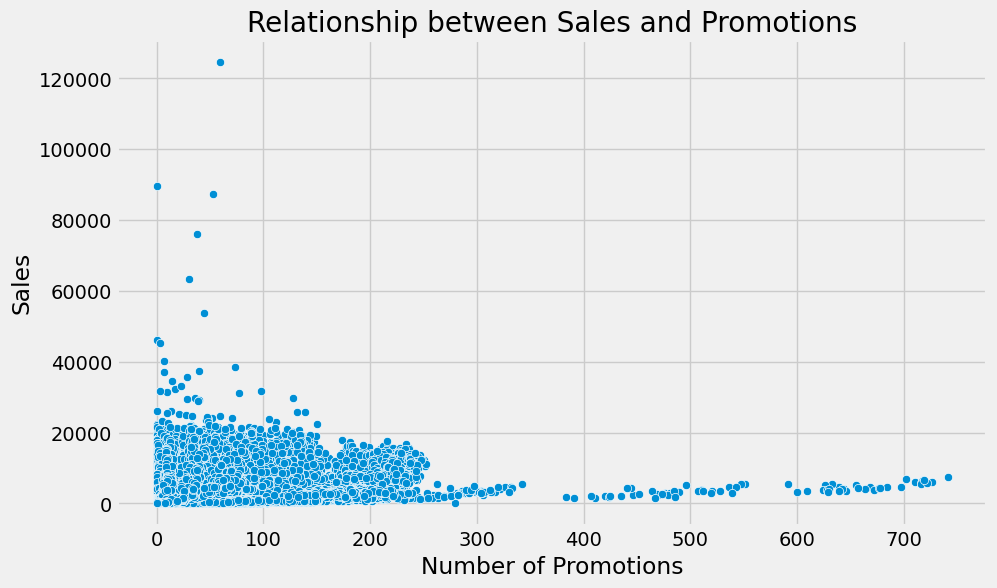

In [ ]:
# Scatter plot exhibiting the relationship between sales and promotions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x='onpromotion', y='sales')
plt.title('Relationship between Sales and Promotions')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
plt.show()

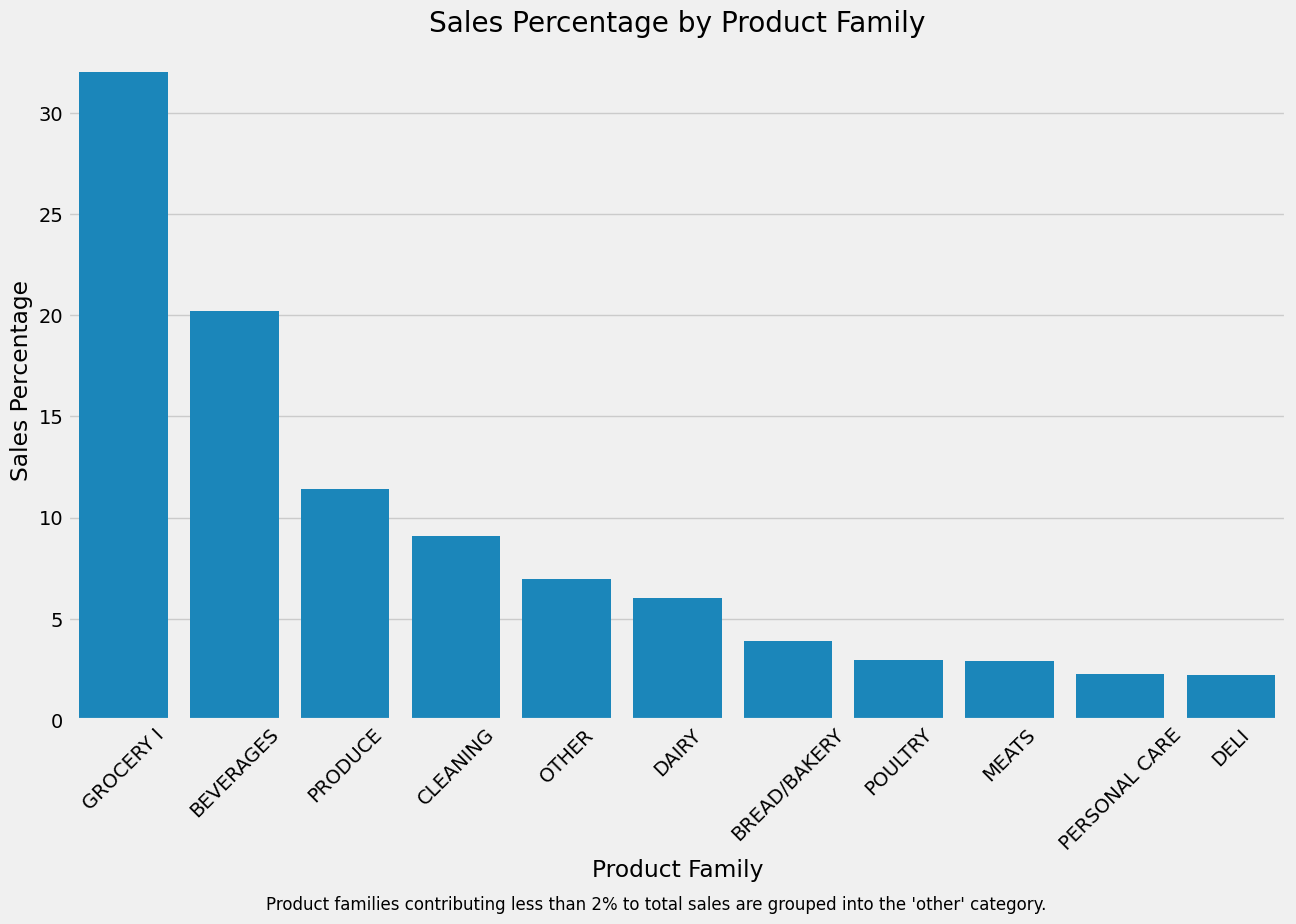

In [ ]:
# Calculate total sales per product family
total_sales = train.groupby('family')['sales'].sum().reset_index()

# Calculate the percentage of total sales per product family
total_sales['percentage'] = (total_sales['sales'] / total_sales['sales'].sum()) * 100

# Separate families with less than 2% of total sales
other_families = total_sales[total_sales['percentage'] < 2]
other_families_sum = other_families['sales'].sum()
other_families_percentage = other_families['percentage'].sum()

# Create a new dataframe for the remaining families and the 'Other' category
remaining_families = total_sales[total_sales['percentage'] >= 2]

# Add the 'Other' category
other_row = pd.DataFrame({'family': ['OTHER'], 'sales': [other_families_sum], 'percentage': [other_families_percentage]})
final_df = pd.concat([remaining_families, other_row], ignore_index=True)

# Sort final_df by sales in descending order
final_df_sorted = final_df.sort_values(by='sales', ascending=False)

# Plot the sales percentage of each product family
plt.figure(figsize=(14, 10))  # Increase figure size for better visibility
bar_plot = sns.barplot(data=final_df_sorted, x='family', y='percentage', order=final_df_sorted['family'])
plt.title('Sales Percentage by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales Percentage')
plt.xticks(rotation=45)

# Annotate each bar with the percentage value
#for index, row in final_df_sorted.iterrows():
#    bar_plot.text(index, row['percentage'], f"{row['percentage']:.2f}%", color='black', ha="center")

# Adjust bottom margin to create more space for x-axis labels
plt.subplots_adjust(bottom=0.2)

# Add text annotation at the bottom of the plot
plt.figtext(0.5, 0.01, "Product families contributing less than 2% to total sales are grouped into the 'other' category.", ha="center", fontsize=12)

plt.show()

In [ ]:
final_df_sorted.head()

,family,sales,percentage
5,GROCERY I,343462734.89,31.99
0,BEVERAGES,216954486.00,20.21
9,PRODUCE,122704684.68,11.43
2,CLEANING,97521289.00,9.08
10,OTHER,74715256.72,6.96


In [ ]:
# Merge the value data with the cities dataframe
sales_per_store = train.merge(stores, on='store_nbr')
sales_per_province = sales_per_store.groupby(['city', 'state'])['sales'].sum().reset_index()


In [ ]:
sales_per_store.head()

,id,date,store_nbr,family,sales,onpromotion,weekday,week,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,Tuesday,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.00,0,Tuesday,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.00,0,Tuesday,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.00,0,Tuesday,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.00,0,Tuesday,0,Quito,Pichincha,D,13


                            state           city        sales  \
4                       Pichincha          Quito 556741836.83   
7                           Other                206916179.50   
2                          Guayas      Guayaquil 122967260.48   
0                           Azuay         Cuenca  49168596.03   
6                      Tungurahua         Ambato  40304401.30   
5  Santo Domingo de los Tsachilas  Santo Domingo  35834323.04   
1                          El Oro        Machala  33386796.54   
3                       Pichincha        Cayambe  28325558.48   

                                       state_city  percentage  
4                               Pichincha - Quito       51.86  
7                                           Other       19.27  
2                              Guayas - Guayaquil       11.45  
0                                  Azuay - Cuenca        4.58  
6                             Tungurahua - Ambato        3.75  
5  Santo Domingo de los Tsachi

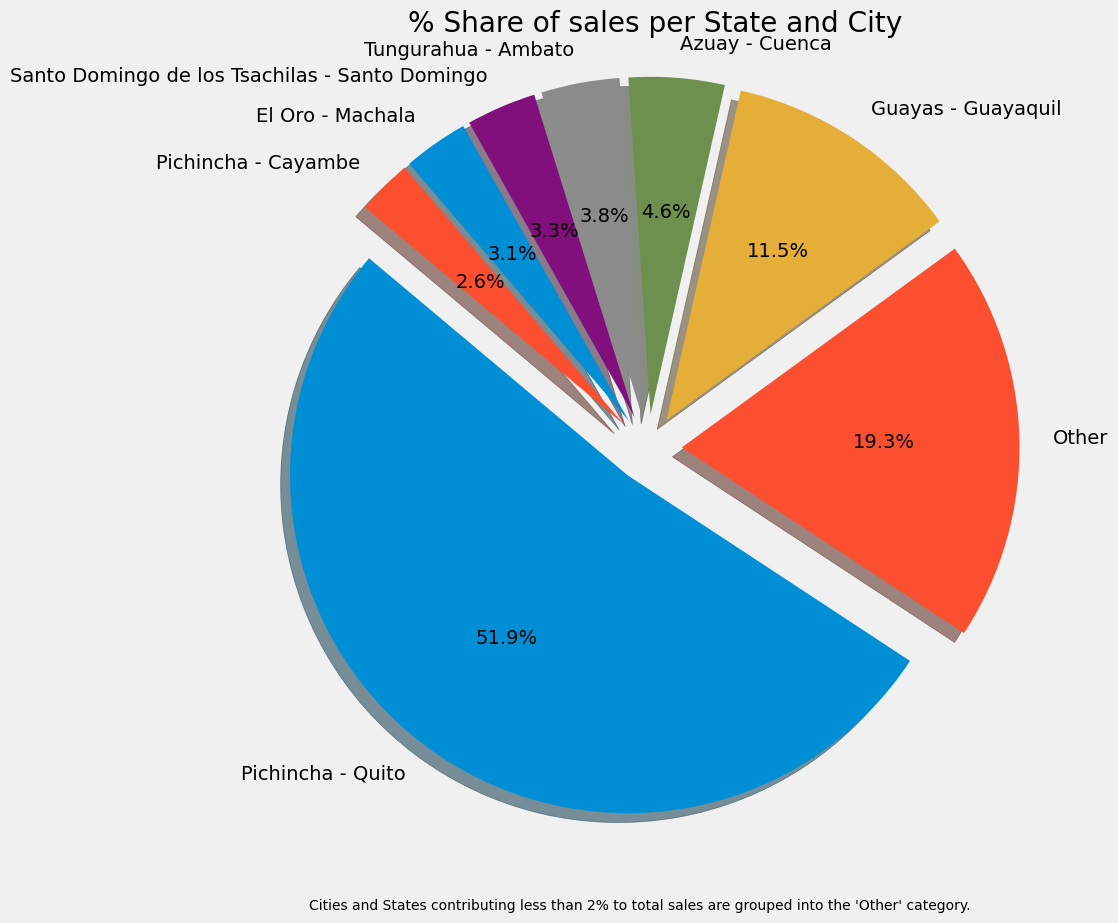

In [ ]:
# Group by state and city and calculate total sales
total_sales_per_state_city = sales_per_store.groupby(['state', 'city'])['sales'].sum().reset_index()

# Create a new column for combined state and city for the pie chart labels
total_sales_per_state_city['state_city'] = total_sales_per_state_city['state'] + " - " + total_sales_per_state_city['city']

# Calculate the percentage of total sales
total_sales = total_sales_per_state_city['sales'].sum()
total_sales_per_state_city['percentage'] = (total_sales_per_state_city['sales'] / total_sales) * 100

# Identify categories with less than 2% of total sales
other_categories = total_sales_per_state_city[total_sales_per_state_city['percentage'] < 2]

# Combine them into an 'Other' category
other_total_sales = other_categories['sales'].sum()
other_percentage = other_categories['percentage'].sum()

# Filter out the 'Other' categories from the main dataframe
total_sales_per_state_city = total_sales_per_state_city[total_sales_per_state_city['percentage'] >= 2]

# Create a DataFrame for the 'Other' category
other_df = pd.DataFrame({
    'state': ['Other'],
    'city': [''],
    'sales': [other_total_sales],
    'state_city': ['Other'],
    'percentage': [other_percentage]
})

# Concatenate the main DataFrame with the 'Other' DataFrame
total_sales_per_state_city = pd.concat([total_sales_per_state_city, other_df], ignore_index=True)

# Sort by percentage
total_sales_per_state_city = total_sales_per_state_city.sort_values(by='percentage', ascending=False)

# Display the resulting dataframe
print(total_sales_per_state_city)


# Plot the total sales per state and city using a pie chart
plt.figure(figsize=(10, 10))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = total_sales_per_state_city['state_city']
sizes = total_sales_per_state_city['sales']
explode = (0.1,) * len(sizes)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('% Share of sales per State and City')

# Adding text below the plot
plt.figtext(0.5, 0.01, "Cities and States contributing less than 2% to total sales are grouped into the 'Other' category.", ha="center", fontsize=10)

plt.show()

# Let's explore the holidays dataset and its impact on sales

In [ ]:
holidays.

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


#Using the prophet model for forecasting the time series

In [ ]:
def prepare_prophet_data(sales_per_store, family):
    family_df = sales_per_store[sales_per_store['family'] == family][['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
    return family_df

# Prepare data for each family
automotive_df = prepare_prophet_data(sales_per_store, 'AUTOMOTIVE')
beverages_df = prepare_prophet_data(sales_per_store, 'BEVERAGES')
grocery_df = prepare_prophet_data(sales_per_store, 'GROCERY I')

In [ ]:
from prophet import Prophet

# Function to fit Prophet model and make future predictions
def fit_prophet_model(train, test):
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq='D')
    forecast = model.predict(future)
    forecast = forecast[['ds', 'yhat']].set_index('ds').join(test.set_index('ds'), how='right')
    return forecast

In [ ]:
# Function to calculate RMSLE
def calculate_rmsle(forecast):
    forecast = forecast.dropna()  # Drop any rows with NaN values
    y_true = forecast['y']
    y_pred = forecast['yhat']
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return rmsle

In [ ]:
# Split data into train and test sets (80% train, 20% test)
def train_test_split(df, test_size=0.2):
    split_index = int(len(df) * (1 - test_size))
    train_df = df[:split_index]
    test_df = df[split_index:]
    return train_df, test_df

In [ ]:
# Apply the process to each family
def evaluate_family(family_df):
    train_df, test_df = train_test_split(family_df)
    forecast = fit_prophet_model(train_df, test_df)
    rmsle = calculate_rmsle(forecast)
    return rmsle, forecast

In [ ]:
beverages_rmsle, beverages_forecast = evaluate_family(beverages_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpali1jdhs/kyyos3pq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpali1jdhs/ny8sb23x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97716', 'data', 'file=/tmp/tmpali1jdhs/kyyos3pq.json', 'init=/tmp/tmpali1jdhs/ny8sb23x.json', 'output', 'file=/tmp/tmpali1jdhs/prophet_modelm78_qrda/prophet_model-20240605102233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
beverages_forecast.tail()

,yhat,y
ds,,
2017-08-15,2903.02,4332.00
2017-08-15,2903.02,2678.00
2017-08-15,2903.02,3999.00
2017-08-15,2903.02,3626.00
2017-08-15,2903.02,3530.00


In [ ]:
grocery_rmsle, grocery_forecast, = evaluate_family(grocery_df)
automotive_rmsle, automotive_forecast = evaluate_family(automotive_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpali1jdhs/i7sd4jau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpali1jdhs/8gotfhwn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56396', 'data', 'file=/tmp/tmpali1jdhs/i7sd4jau.json', 'init=/tmp/tmpali1jdhs/8gotfhwn.json', 'output', 'file=/tmp/tmpali1jdhs/prophet_modeli4u7m4jo/prophet_model-20240605102325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpal

In [ ]:
automotive_rmsle

0.8921901413678945

In [ ]:
beverages_rmsle

2.6129304569079492

In [ ]:
grocery_rmsle

2.805618573935281

In [ ]:
def plot_actual_vs_predicted(df, actual_column='y', predicted_column='yhat', figsize=(12, 6)):
    plt.figure(figsize=figsize)

    # Reset the index of the DataFrame
    df_reset = df.reset_index()

    plt.plot(df_reset['ds'], df_reset[actual_column], label='Actual', color='blue')
    plt.plot(df_reset['ds'], df_reset[predicted_column], label='Predicted', color='red')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()

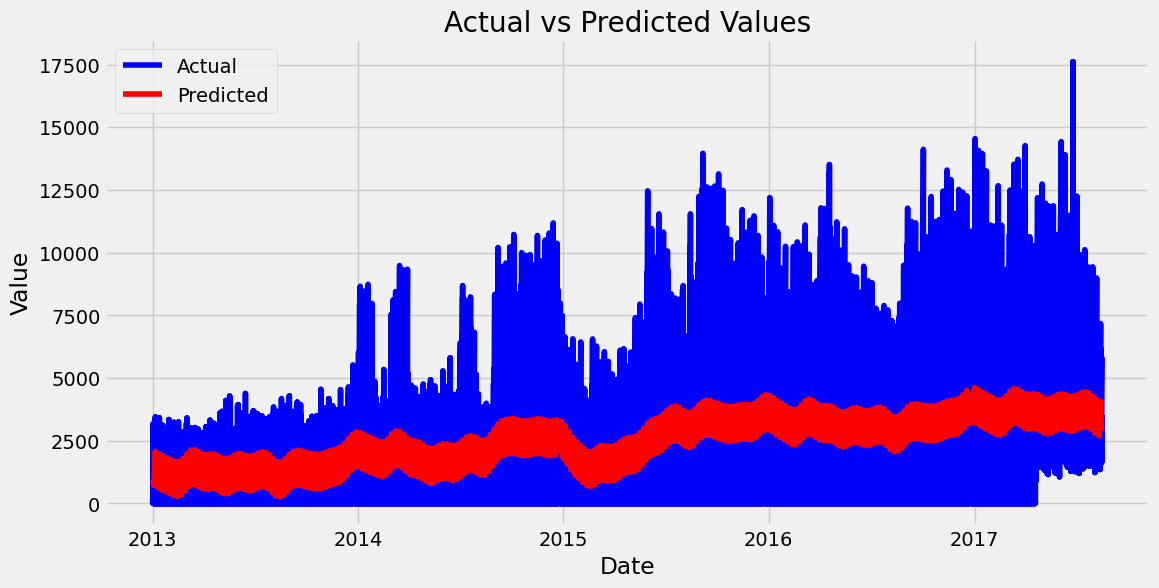

In [ ]:
plot_actual_vs_predicted(beverages_forecast)

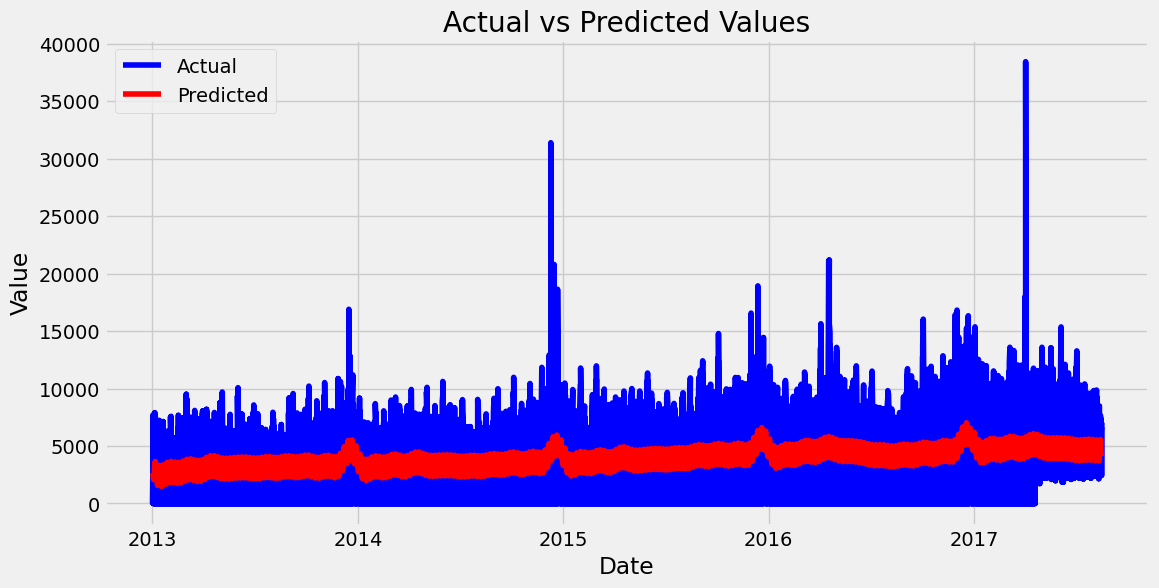

In [ ]:
plot_actual_vs_predicted(grocery_forecast)

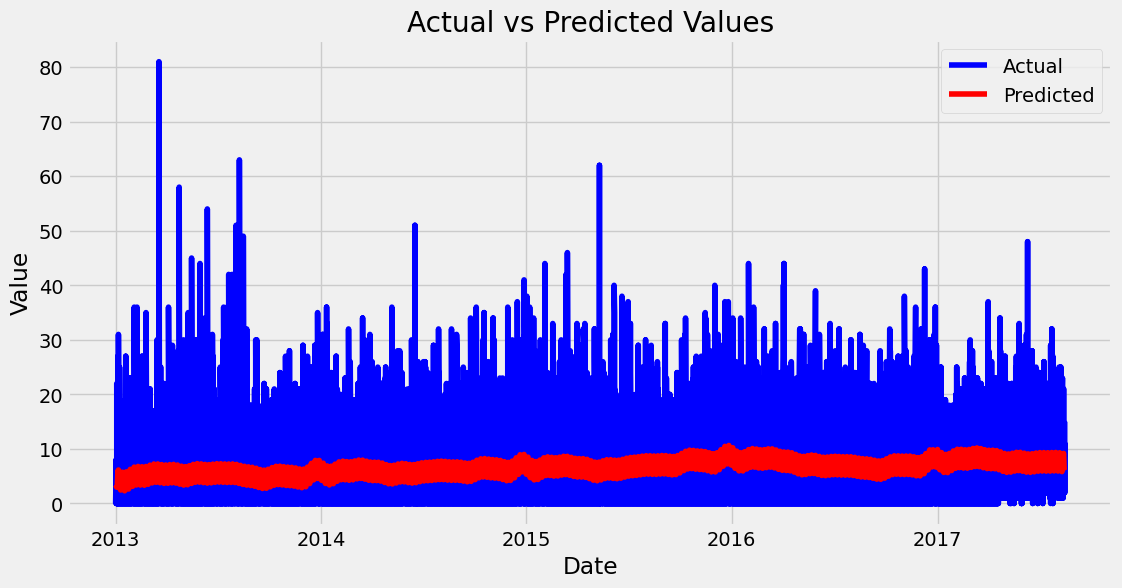

In [ ]:
plot_actual_vs_predicted(automotive_forecast)

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,weekday,week,year,month
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,Tuesday,0,2013,1
1,1,2013-01-01,1,BABY CARE,0.00,0,Tuesday,0,2013,1
2,2,2013-01-01,1,BEAUTY,0.00,0,Tuesday,0,2013,1
3,3,2013-01-01,1,BEVERAGES,0.00,0,Tuesday,0,2013,1
4,4,2013-01-01,1,BOOKS,0.00,0,Tuesday,0,2013,1
